# Transfer Learning with VGGFace VGG16 and ResNet50

In [1]:
## Importing the Keras libraries and packages
# import os
# import cv2 
import numpy as np
import pandas as pd 
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace


Using TensorFlow backend.


In [2]:
#Setting Cuda Visible Devices to 1 for the tf-gpu version to work properly
CUDA_VISIBLE_DEVICES = 1

## Load Data:

In [3]:
#now we're loading in the images with the Keras ImageDataGenerator module
from keras.preprocessing.image import ImageDataGenerator

# Anwalt_Call, Arzt_Anwalt, Kfz_Arzt, Arzt_Call, Kfz_Anwalt, Kfz_Call
# BauBE_KunstBE, BauCeo_BauBE, BauCeo_KunstBE, BauCeo_KunstCeo, KunstCeo_BauBE, KunstCeo_KunstBE
# FinBE_KomCeo, IndBE_KunstCeo 

#Setting paths and parameters: 
train_dir = r'C:\Users\melte\Desktop\ML\Binary\Block1\Anwalt_Call\Train'
test_dir = r'C:\Users\melte\Desktop\ML\Binary\Block1\Anwalt_Call\Test'
val_dir = r'C:\Users\melte\Desktop\ML\Binary\Block1\Anwalt_Call\Val'

nTrain = 76
nTest = 24
nVal = 20

# nTrain = 768
# nTest = 240 
# nVal = 192 

c = 2   #classes
batch_size = 20

#######################
### DATA GENERATOR ####
#######################

datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#############################################
### LOADING IN TRAIN, TEST AND VALIDATION SETS ####
#############################################

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 76 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [4]:
#Let's initiate our feature and label arrays: 
train_features = np.zeros(shape=(nTrain, 1 , 1 , 2048))
train_labels = np.zeros(shape=(nTrain,c))

test_features = np.zeros(shape=(nTest, 1 , 1 , 2048))
test_labels = np.zeros(shape=(nTest,c))

val_features = np.zeros(shape=(nVal, 1 , 1 , 2048))
val_labels = np.zeros(shape=(nVal,c))

## Import VGG Network

In [5]:
#This is the pretrained network we're using for transfer learning: 
# model = resnet50 or vgg16
model_vgg16 = VGGFace(model='resnet50',include_top=False, input_shape=(224, 224, 3))

In [6]:
# model_vgg16 = Model(inputs=base_model.input, outputs=base_model.get_layer('activation_48').output)

In [7]:
# #This is what the model looks like
# model_vgg16.summary()

## Creating the feature vectors for our train and validation sets:

In [8]:
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = model_vgg16.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break       
train_features = np.reshape(train_features, (nTrain, 1 * 1 * 2048))

i = 0
for inputs_batch, labels_batch in test_generator:
    features_batch = model_vgg16.predict(inputs_batch)
    test_features[i * batch_size : (i + 1) * batch_size] = features_batch
    test_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTest:
        break       
test_features = np.reshape(test_features, (nTest, 1 * 1 * 2048))


i = 0
for inputs_batch, labels_batch in val_generator:
    features_batch_val = model_vgg16.predict(inputs_batch)
    val_features[i * batch_size : (i + 1) * batch_size] = features_batch_val
    val_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break         
val_features = np.reshape(val_features, (nVal, 1 * 1 * 2048))

## Create and train NN for classification using extracted features 

In [9]:
from keras import models
from keras import layers
from keras import optimizers
 
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=1 * 1 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(c, activation='softmax'))

In [10]:
#loss functions: mean_squared_error , mean_squared_logarithmic_error, categorical_crossentropy
#optimizers: SGD , Adam

model.compile(optimizer='Adam',
              loss='mean_squared_logarithmic_error',
              metrics=['acc'])
 
history = model.fit(train_features,
                    train_labels,
                    epochs=50,
                    batch_size=70, #Loss 1.9-2.5 with size 5
                    validation_data=(val_features,val_labels))

Train on 76 samples, validate on 20 samples
Epoch 1/50
76/76 [==============================] - 1s 13ms/step - loss: 0.1526 - acc: 0.4868 - val_loss: 0.1332 - val_acc: 0.5000
Epoch 2/50
76/76 [==============================] - 0s 551us/step - loss: 0.1362 - acc: 0.5263 - val_loss: 0.1241 - val_acc: 0.5000
Epoch 3/50
76/76 [==============================] - 0s 577us/step - loss: 0.1403 - acc: 0.5526 - val_loss: 0.1246 - val_acc: 0.5000
Epoch 4/50
76/76 [==============================] - 0s 696us/step - loss: 0.1438 - acc: 0.4868 - val_loss: 0.1318 - val_acc: 0.5000
Epoch 5/50
76/76 [==============================] - 0s 656us/step - loss: 0.1439 - acc: 0.5132 - val_loss: 0.1262 - val_acc: 0.5000
Epoch 6/50
76/76 [==============================] - 0s 604us/step - loss: 0.1241 - acc: 0.5789 - val_loss: 0.1261 - val_acc: 0.5000
Epoch 7/50
76/76 [==============================] - 0s 577us/step - loss: 0.1275 - acc: 0.5395 - val_loss: 0.1422 - val_acc: 0.5000
Epoch 8/50
76/76 [===============

## Visualize Performance

In [11]:
fnames = test_generator.filenames
 
ground_truth = test_generator.classes
 
label2index = test_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
predictions = model.predict_classes(test_features)
prob = model.predict(test_features)
 
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nTest))

No of errors = 12/24


### Quality Analysis:

Original label:Anwalt\Anwalt (13).jpg, Prediction :Call, confidence : 0.603


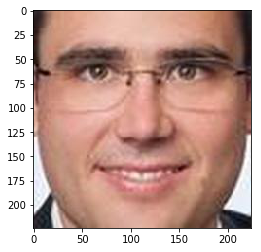

Original label:Anwalt\Anwalt (17).jpg, Prediction :Call, confidence : 0.602


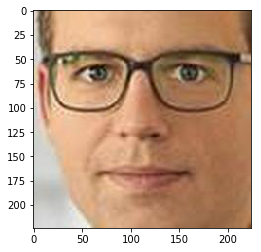

Original label:Anwalt\Anwalt (2).jpg, Prediction :Call, confidence : 0.599


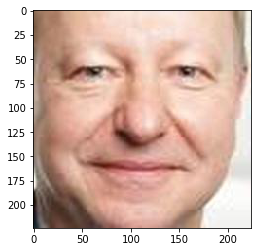

Original label:Anwalt\Anwalt (22).jpg, Prediction :Call, confidence : 0.601


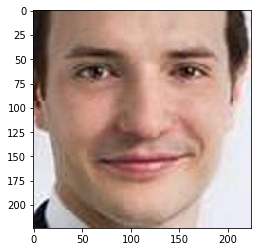

Original label:Anwalt\Anwalt (26).jpg, Prediction :Call, confidence : 0.602


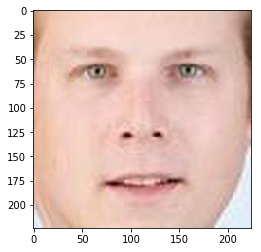

Original label:Anwalt\Anwalt (30).jpg, Prediction :Call, confidence : 0.601


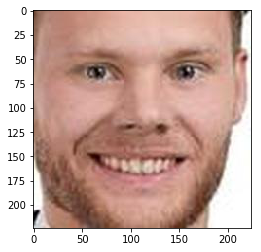

Original label:Anwalt\Anwalt (33).jpg, Prediction :Call, confidence : 0.602


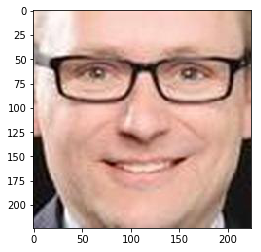

Original label:Anwalt\Anwalt (41).jpg, Prediction :Call, confidence : 0.603


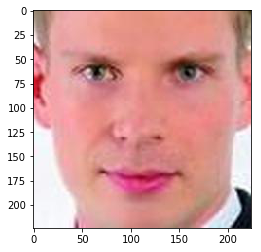

Original label:Anwalt\Anwalt (46).jpg, Prediction :Call, confidence : 0.601


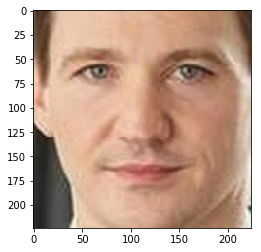

Original label:Anwalt\Anwalt (51).jpg, Prediction :Call, confidence : 0.601


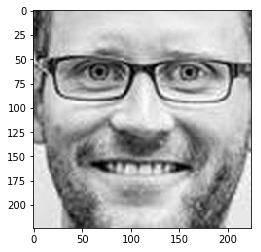

Original label:Anwalt\Anwalt (56).jpg, Prediction :Call, confidence : 0.601


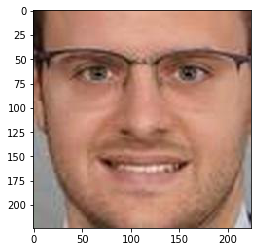

Original label:Anwalt\Anwalt (9).jpg, Prediction :Call, confidence : 0.603


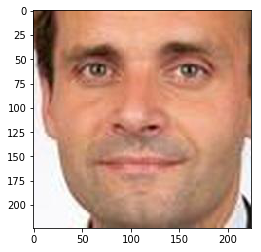

In [12]:
from keras.preprocessing import image

for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
     
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
     
    original = image.load_img('{}/{}'.format(test_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()


### Plotting the Accuracy and the Loss of our Model:

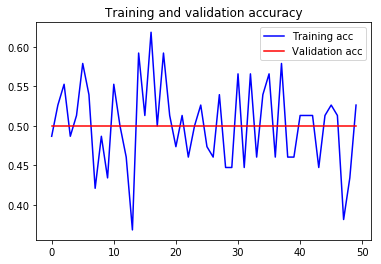

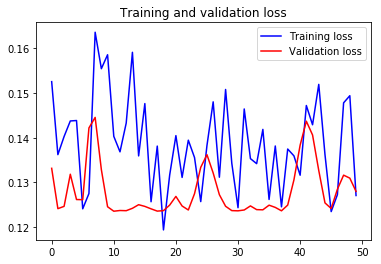

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()


In [14]:
score = model.evaluate(test_features, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12788580358028412
Test accuracy: 0.5


## SVM 

In [15]:
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.svm import SVC 

SVM = SVC(kernel = 'rbf', gamma='scale', C=20)
SVM.fit(train_features, train_labels[:,0])


train_SVM = SVM.predict(train_features)
val_SVM = SVM.predict(val_features)
test_SVM = SVM.predict(test_features)


print("\nrSVM - Train Confusion Matrix\n\n",
      pd.crosstab(train_labels[:,0], train_SVM, rownames = ["Actual"], colnames = ["Predicted"]))
print("\nrSVM - Train Accuracy:", round(accuracy_score(train_labels[:,0], train_SVM),3))
print("\nrSVM - Train Classification Report\n",classification_report(train_labels[:,0], train_SVM)) 


print("\n\nrSVM - Val Confusion Matrix\n\n",
      pd.crosstab(val_labels[:,0], val_SVM, rownames = ["Actual"], colnames = ["Predicted"]))
print("\nrSVM - Val Accuracy:", round(accuracy_score(val_labels[:,0], val_SVM),3))
print("\nrSVM - Test Classification Report\n",classification_report(val_labels[:,0], val_SVM))

print("\n\nrSVM - Test Confusion Matrix\n\n",
      pd.crosstab(test_labels[:,0], test_SVM, rownames = ["Actual"], colnames = ["Predicted"]))
print("\nrSVM - Test Accuracy:", round(accuracy_score(test_labels[:,0], test_SVM),3))
print("\nrSVM - Test Classification Report\n",classification_report(test_labels[:,0], test_SVM))


rSVM - Train Confusion Matrix

 Predicted  0.0  1.0
Actual             
0.0         34    4
1.0         25   13

rSVM - Train Accuracy: 0.618

rSVM - Train Classification Report
               precision    recall  f1-score   support

         0.0       0.58      0.89      0.70        38
         1.0       0.76      0.34      0.47        38

   micro avg       0.62      0.62      0.62        76
   macro avg       0.67      0.62      0.59        76
weighted avg       0.67      0.62      0.59        76



rSVM - Val Confusion Matrix

 Predicted  0.0  1.0
Actual             
0.0          9    1
1.0          7    3

rSVM - Val Accuracy: 0.6

rSVM - Test Classification Report
               precision    recall  f1-score   support

         0.0       0.56      0.90      0.69        10
         1.0       0.75      0.30      0.43        10

   micro avg       0.60      0.60      0.60        20
   macro avg       0.66      0.60      0.56        20
weighted avg       0.66      0.60      0.56    

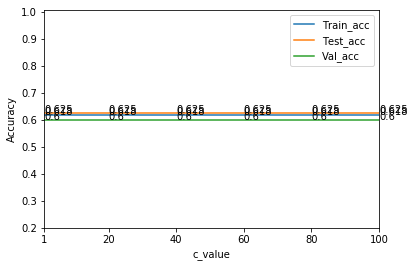

In [16]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, classification_report


array = np.empty((5,4))
k_valchart = pd.DataFrame(array)
k_valchart.columns = ["c_value", "Train_acc", "Val_acc", "Test_acc"]

vals = [1,20,40,60,80,100]

for i in range (len(vals)):
    SVM = SVC(kernel = 'rbf', gamma = 'scale', C=(vals[i]))
    SVM.fit(train_features, train_labels[:,0])
    train_SVM = SVM.predict(train_features)
    test_SVM = SVM.predict(test_features)
    val_SVM = SVM.predict(val_features)
    
    tr_accscore = round(accuracy_score(train_labels[:,0], train_SVM), 3)
    test_accscore = round(accuracy_score(test_labels[:,0], test_SVM), 3)
    val_accscore = round(accuracy_score(val_labels[:,0], val_SVM), 3)
    
    k_valchart.loc[i, 'c_value'] = vals[i]
    k_valchart.loc[i, 'Train_acc'] = tr_accscore
    k_valchart.loc[i, 'Test_acc'] = test_accscore
    k_valchart.loc[i, 'Val_acc'] = val_accscore
    
#PLOTTING ACCURACIES OVER DIFFERENT K VALUES 
plt.figure() 
plt.xlabel('c_value')
plt.ylabel('Accuracy')
plt.plot(k_valchart["c_value"], k_valchart["Train_acc"])
plt.plot(k_valchart["c_value"], k_valchart["Test_acc"])
plt.plot(k_valchart["c_value"], k_valchart["Val_acc"])

plt.axis([0.9, 5, 0.2, 1.005])
plt.xticks([1,20,40,60,80,100])

for a,b in zip(k_valchart["c_value"], k_valchart["Train_acc"]):
    plt.text(a, b, str(b), fontsize = 10)

for a,b in zip(k_valchart["c_value"], k_valchart["Test_acc"]):
    plt.text(a, b, str(b), fontsize = 10)
    
for a,b in zip(k_valchart["c_value"], k_valchart["Val_acc"]):
    plt.text(a, b, str(b), fontsize = 10)
    
plt.legend(loc = 'upper right')
plt.show()

## KNN Classifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, classification_report


knn_fit = KNeighborsClassifier(n_neighbors = 10, p = 2, metric = 'minkowski')

knn_fit.fit(train_features, train_labels[:,0])

train_res = knn_fit.predict(train_features)
val_res = knn_fit.predict(val_features)
test_res = knn_fit.predict(test_features)
# print(train_res)

print("\nrSVM - Train Confusion Matrix\n\n",
      pd.crosstab(train_labels[:,0], train_SVM, rownames = ["Actual"], colnames = ["Predicted"]))
print("\nrSVM - Train Accuracy:", round(accuracy_score(train_labels[:,0], train_SVM),3))
print("\nrSVM - Train Classification Report\n",classification_report(train_labels[:,0], train_SVM)) 


print("\n\nrSVM - Val Confusion Matrix\n\n",
      pd.crosstab(val_labels[:,0], val_SVM, rownames = ["Actual"], colnames = ["Predicted"]))
print("\nrSVM - Val Accuracy:", round(accuracy_score(val_labels[:,0], val_SVM),3))
print("\nrSVM - Test Classification Report\n",classification_report(val_labels[:,0], val_SVM))

print("\n\nrSVM - Test Confusion Matrix\n\n",
      pd.crosstab(test_labels[:,0], test_SVM, rownames = ["Actual"], colnames = ["Predicted"]))
print("\nrSVM - Test Accuracy:", round(accuracy_score(test_labels[:,0], test_SVM),3))
print("\nrSVM - Test Classification Report\n",classification_report(test_labels[:,0], test_SVM))


rSVM - Train Confusion Matrix

 Predicted  0.0  1.0
Actual             
0.0         34    4
1.0         25   13

rSVM - Train Accuracy: 0.618

rSVM - Train Classification Report
               precision    recall  f1-score   support

         0.0       0.58      0.89      0.70        38
         1.0       0.76      0.34      0.47        38

   micro avg       0.62      0.62      0.62        76
   macro avg       0.67      0.62      0.59        76
weighted avg       0.67      0.62      0.59        76



rSVM - Val Confusion Matrix

 Predicted  0.0  1.0
Actual             
0.0          9    1
1.0          7    3

rSVM - Val Accuracy: 0.6

rSVM - Test Classification Report
               precision    recall  f1-score   support

         0.0       0.56      0.90      0.69        10
         1.0       0.75      0.30      0.43        10

   micro avg       0.60      0.60      0.60        20
   macro avg       0.66      0.60      0.56        20
weighted avg       0.66      0.60      0.56    

### Plotting accuracies for varying K values:

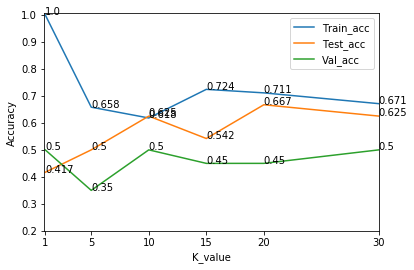

In [18]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, classification_report

array = np.empty((5,4))
k_valchart = pd.DataFrame(array)
k_valchart.columns = ["K_value", "Train_acc", "Test_acc", "Val_acc"]

k_vals = [1,5,10,15,20,30]

for i in range (len(k_vals)):
    knn_fit = KNeighborsClassifier(n_neighbors = k_vals[i], p=2, metric='minkowski')
    knn_fit.fit(train_features, train_labels[:,0])
    tr_accscore = round(accuracy_score(train_labels[:,0], knn_fit.predict(train_features)), 3)
    test_accscore = round(accuracy_score(test_labels[:,0], knn_fit.predict(test_features)), 3)
    val_accscore = round(accuracy_score(val_labels[:,0], knn_fit.predict(val_features)), 3)
    
    k_valchart.loc[i, 'K_value'] = k_vals[i]
    k_valchart.loc[i, 'Train_acc'] = tr_accscore
    k_valchart.loc[i, 'Test_acc'] = test_accscore
    k_valchart.loc[i, 'Val_acc'] = val_accscore
    
#PLOTTING ACCURACIES OVER DIFFERENT K VALUES 
plt.figure() 
plt.xlabel('K_value')
plt.ylabel('Accuracy')
plt.plot(k_valchart["K_value"], k_valchart["Train_acc"])
plt.plot(k_valchart["K_value"], k_valchart["Test_acc"])
plt.plot(k_valchart["K_value"], k_valchart["Val_acc"])

plt.axis([0.9, 5, 0.2, 1.005])
plt.xticks([1,5,10,15,20,30])

for a,b in zip(k_valchart["K_value"], k_valchart["Train_acc"]):
    plt.text(a, b, str(b), fontsize = 10)
    
for a,b in zip(k_valchart["K_value"], k_valchart["Test_acc"]):
    plt.text(a, b, str(b), fontsize = 10)
    
for a,b in zip(k_valchart["K_value"], k_valchart["Val_acc"]):
    plt.text(a, b, str(b), fontsize = 10)
    
plt.legend(loc = 'upper right')
plt.show()